# S&P Price Prediction
In this project, we will predict the future S&P 500 index price using a Recurrent Neural Network (RNN).

Dataset: https://www.kaggle.com/datasets/gkitchen/s-and-p-500-spy

Epoch 1/50 complete, Training Loss: 0.0009
Epoch 2/50 complete, Training Loss: 0.0019
Epoch 3/50 complete, Training Loss: 0.0018
Epoch 4/50 complete, Training Loss: 0.0018
Epoch 5/50 complete, Training Loss: 0.0018
Epoch 6/50 complete, Training Loss: 0.0017
Epoch 7/50 complete, Training Loss: 0.0017
Epoch 8/50 complete, Training Loss: 0.0017
Epoch 9/50 complete, Training Loss: 0.0016
Epoch 10/50 complete, Training Loss: 0.0016
Epoch 11/50 complete, Training Loss: 0.0016
Epoch 12/50 complete, Training Loss: 0.0015
Epoch 13/50 complete, Training Loss: 0.0015
Epoch 14/50 complete, Training Loss: 0.0014
Epoch 15/50 complete, Training Loss: 0.0014
Epoch 16/50 complete, Training Loss: 0.0014
Epoch 17/50 complete, Training Loss: 0.0013
Epoch 18/50 complete, Training Loss: 0.0013
Epoch 19/50 complete, Training Loss: 0.0013
Epoch 20/50 complete, Training Loss: 0.0012
Epoch 21/50 complete, Training Loss: 0.0012
Epoch 22/50 complete, Training Loss: 0.0012
Epoch 23/50 complete, Training Loss: 0.00

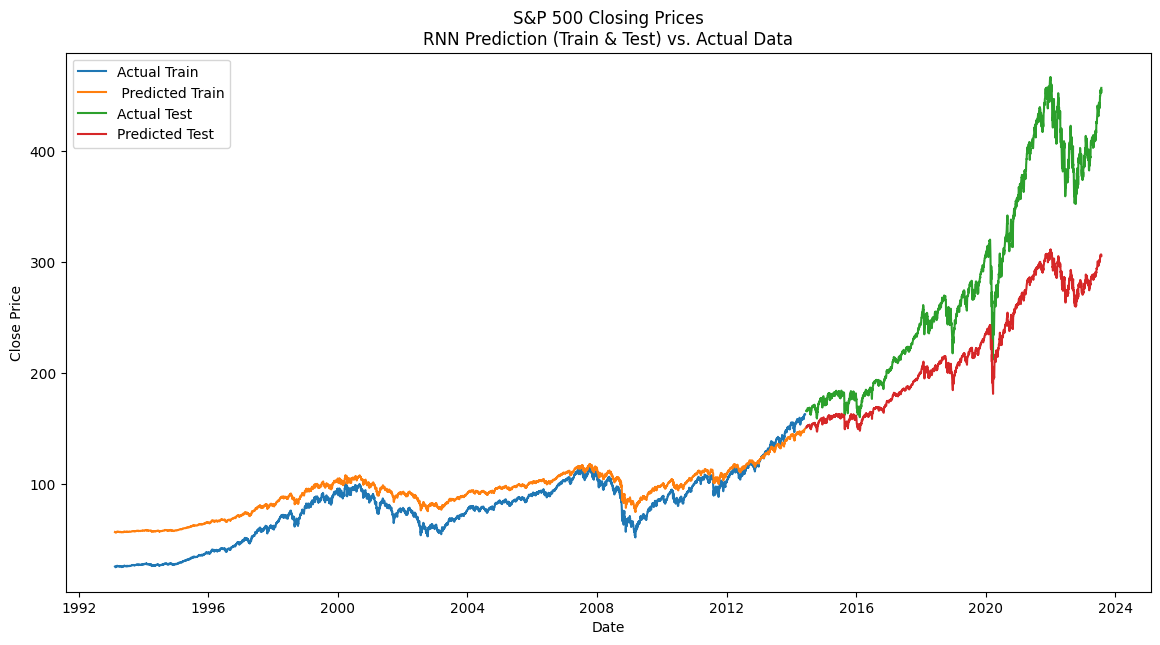

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


class RNN:
    # Hyperparameters
    learningRate = 0
    numEpochs = 0

    # Weights
    weightsIH = None  # Input to hidden (1x1)
    weightsHH = None  # Hidden to Hidden (1x1)
    weightsHO = None  # Hidden to output (1x1)

    # Bias
    hidBias = None  # Bias term for hidden layer (1x1)
    outBias = None  # Bias term for output layer (1x1)

    # Store hidden output for each time step
    outputs = None  # (10x1) dimension in this particular case

    # Constructor
    def __init__(self, learningRate, epochs):
        # Initialize hyperparameters
        self.learningRate = learningRate
        self.numEpochs = epochs

        # Initialize weights randomly
        self.weightsIH = np.random.randn(1, 1)
        self.Whh = np.random.randn(1, 1)
        self.weightsHO = np.random.randn(1, 1)

        self.hidBias = np.random.randn(1, 1) * 0.01
        self.outBias = np.random.randn(1, 1) * 0.01

        self.outputs = np.zeros((10, 1))
        self.scaler = MinMaxScaler()

    # Preprocess data (returns train/test split)
    def preprocess(self, df):
        df = df.drop(
            [
                "Date",
                "Open",
                "High",
                "Low",
                "Volume",
                "Day",
                "Weekday",
                "Week",
                "Month",
                "Year",
            ],
            axis=1,
            errors="ignore",
        )
        data = df["Close"].values.reshape(-1, 1)
        data_scaled = self.scaler.fit_transform(data)
        split = int(len(data_scaled) * 0.7)  # 70% train, 30% test
        return data_scaled[:split], data_scaled[split:]

    # RNN train
    def train(self, data):
        # We want to repeatedly pick a sequence of 10 days and call forward pass on them
        # Pass the result along with the given day 11 value to backward pass

        # Whenever we make a prediction for the last day in train data and make a backward pass on it,
        # we consider 1 epoch to be completed

        n = data.shape[0]  # Number of data points

        for epoch in range(self.numEpochs):
            cumulativeLoss = 0  # Loss for this epoch

            for i in range(n - 10):
                # Take a time slice of 10 days
                prices = data[i : i + 10]
                targetPrice = data[i + 10]

                # Perform forward pass
                pred = self.forwardPass(prices)

                # Calculate loss (mean squared error)
                loss = np.square(pred - targetPrice).mean()
                cumulativeLoss += loss

                # Calling the gradient function
                grad = self.gradient(prices, targetPrice, pred)

                # Updating weights via backPass
                self.backwardPass(grad)

            averageError = cumulativeLoss / (n - 10)
            print(
                f"Epoch {epoch+1}/{self.numEpochs} complete, Training Loss: {averageError:.4f}"
            )

    # RNN Test
    def test(self, data):
        pred = []
        for i in range(len(data) - 10):
            s = data[i : i + 10]
            p = self.forwardPass(s)
            pred.append(p.flatten()[0])
        return np.array(pred)

    # Tanh Activation function
    def tanh(self, x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    # Forward Pass
    # Input: List of 10 closing prices
    # Output: Predicted closing price for 11th day
    def forwardPass(self, x):
        h = np.zeros((1, 1))

        # As we loop through each timestep, we apply tanh activation on Wx and store that output in O
        for t in range(len(x)):
            # Input to activation (dot product of weights with input of timestep t)
            outputIH = np.dot(
                self.weightsIH,
                x[t].reshape(1, 1),  # Reshaping the input to matrix/vector from scalar
            )

            # Pass input to tanh activation function and update the hidden state
            self.outputs[t] = h = self.tanh(
                (outputIH + np.dot(self.Whh, h) + self.hidBias)
            )

        # Return prediction for Day 11
        # Since we are working on a regression problem we use linear activation for the output
        output = np.dot(self.weightsHO, self.outputs[-1]) + self.outBias
        return output

    # Calculate Gradient
    def gradient(self, x, y, output):
        # We need to calculate the following gradients (deltas)
        # dWih,dWhh,dWho
        # dHidBias,dOutBias

        deltaWeightsIH = np.zeros((1, 1))
        deltaWeightsHH = np.zeros((1, 1))
        deltaWeightsHO = np.zeros((1, 1))

        deltaHiddenBias = np.zeros((1, 1))
        deltaOutputBias = np.zeros((1, 1))

        # dl/dWho = dl/doutput * doutput/dWho
        # This simplifies to (output - y) * outputs[t]
        deltaWeightsHO = np.dot((output - y), self.outputs[-1].T)

        # Similarly dOutBias=dl/doutput * doutput/doutBias
        deltaOutputBias = output - y

        # Upon calculation we identified
        # dL/dWih= summation of t from 1 to 10 (dL/doutput*doutput/dO[t]*dO[t]/dWih)
        # dL/dWhh= summation of t from 1 to 10 (dL/doutput*doutput/dO[t]*dO[t]/dWhh)

        # Backpropagation through time (BPTT)
        dLdOt = np.zeros((1, 1))
        for t in reversed(range(len(x))):
            if t == 9:
                dLdOt = (output - y) * self.weightsHO

            dLdOt = np.dot(dLdOt, (1 - (self.outputs[t] ** 2)))
            deltaWeightsIH += np.dot(dLdOt, self.outputs[t].reshape(1, 1).T)

            if t > 0:
                deltaWeightsHH += np.dot(dLdOt, self.outputs[t - 1].T)

            deltaHiddenBias += dLdOt
            dLdOt = np.dot(self.Whh.T, dLdOt)

        return (
            deltaWeightsIH,
            deltaWeightsHH,
            deltaWeightsHO,
            deltaHiddenBias,
            deltaOutputBias,
        )

    # Back Propogation
    def backwardPass(self, gradient):
        dWih, dWhh, dWho, dHidBias, dOutBias = gradient

        # Updating the weight matrices with gradients
        self.weightsIH -= self.learningRate * dWih
        self.Whh -= self.learningRate * dWhh
        self.weightsHO -= self.learningRate * dWho

        # Updating bias terms
        self.hidBias -= self.learningRate * dHidBias
        self.outBias -= self.learningRate * dOutBias


# Fetch dataset
url = (
    "https://drive.google.com/file/d/1DaacpG9bD-KAu_xmIWOS7MVlhrwNa9jr/view?usp=sharing"
)
file_id = url.split("/")[-2]
dataFile = "https://drive.google.com/uc?id=" + file_id
df = pd.read_csv(dataFile, parse_dates=True, index_col=0)

# Ensure reproducibility of results
np.random.seed(42)

# Initialize RNN (tune hyperparameters here)
rnn = RNN(learningRate=0.001, epochs=50)

# Preprocess data
train_df, test_df = rnn.preprocess(df)

# Train the RNN
rnn.train(train_df)

# Test the RNN
train_predictions = rnn.test(train_df)
test_predictions = rnn.test(test_df)

# Evaluation
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(train_df[10:], train_predictions.reshape(-1, 1))
test_mae = mean_absolute_error(test_df[10:], test_predictions.reshape(-1, 1))
print(f"Training MAE: {round(train_mae, 3)}")
print(f"Testing MAE: {round(test_mae, 3)}")

# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(train_df[10:], train_predictions.reshape(-1, 1)))
test_rmse = np.sqrt(mean_squared_error(test_df[10:], test_predictions.reshape(-1, 1)))
print(f"Training RMSE: {round(train_rmse, 3)}")
print(f"Testing RMSE: {round(test_rmse, 3)}")

# Graph the model's prediction versus the data
plt.figure(figsize=(14, 7))

plt.plot(
    df.index[10 : len(train_predictions) + 10],
    rnn.scaler.inverse_transform(train_df[10:]),
    label="Actual Train",
)
plt.plot(
    df.index[10 : len(train_predictions) + 10],
    rnn.scaler.inverse_transform(train_predictions.reshape(-1, 1)),
    label=" Predicted Train",
)

plt.plot(
    df.index[len(train_df) + 10 : len(train_df) + 10 + len(test_predictions)],
    rnn.scaler.inverse_transform(test_df[10:]),
    label="Actual Test",
)
plt.plot(
    df.index[len(train_df) + 10 : len(train_df) + 10 + len(test_predictions)],
    rnn.scaler.inverse_transform(test_predictions.reshape(-1, 1)),
    label="Predicted Test",
)

plt.title("S&P 500 Closing Prices\nRNN Prediction (Train & Test) vs. Actual Data")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
import math

np.random.seed(42)

# AUTOMATED HYPERPARAMETER TUNING (takes some time)
# Goes through different values for learning rate & epochs to find optimal hyperparameters
learningRate = 0.00001
minRMSE = math.inf
bestLearningRate = math.inf
while learningRate < 1:
    # Initialize RNN (tune hyperparameters here)
    rnn = RNN(learningRate=learningRate, epochs=30)

    # Preprocess data
    train_df, test_df = rnn.preprocess(df)

    # Train the RNN
    rnn.train(train_df)

    # Test the RNN
    train_predictions = rnn.test(train_df)
    test_predictions = rnn.test(test_df)

    # Calculate test RMSE
    test_rmse = np.sqrt(mean_squared_error(test_df[10:], test_predictions.reshape(-1, 1)))
    if test_rmse < minRMSE:
        minRMSE = test_rmse
        bestLearningRate = learningRate

    learningRate *= 10

print(f"Best learning rate: {bestLearningRate}")

Epoch 1/30 complete, Training Loss: 0.0085
Epoch 2/30 complete, Training Loss: 0.0077
Epoch 3/30 complete, Training Loss: 0.0070
Epoch 4/30 complete, Training Loss: 0.0064
Epoch 5/30 complete, Training Loss: 0.0058
Epoch 6/30 complete, Training Loss: 0.0054
Epoch 7/30 complete, Training Loss: 0.0050
Epoch 8/30 complete, Training Loss: 0.0046
Epoch 9/30 complete, Training Loss: 0.0043
Epoch 10/30 complete, Training Loss: 0.0041
Epoch 11/30 complete, Training Loss: 0.0038
Epoch 12/30 complete, Training Loss: 0.0036
Epoch 13/30 complete, Training Loss: 0.0035
Epoch 14/30 complete, Training Loss: 0.0033
Epoch 15/30 complete, Training Loss: 0.0032
Epoch 16/30 complete, Training Loss: 0.0031
Epoch 17/30 complete, Training Loss: 0.0030
Epoch 18/30 complete, Training Loss: 0.0029
Epoch 19/30 complete, Training Loss: 0.0028
Epoch 20/30 complete, Training Loss: 0.0028
Epoch 21/30 complete, Training Loss: 0.0027
Epoch 22/30 complete, Training Loss: 0.0027
Epoch 23/30 complete, Training Loss: 0.00